In [1]:
print('hello world')


hello world


In [1]:
import os
import pandas as pd
import numpy as np
import utils.tools as tools
import utils.calculators as calculators
import factor_gen.y as y
import mat73
from heapq import nlargest
from heapq import nsmallest
from factor_filter.factor_filter import PerformanceWithCost

def load_data_from_PX(path):
    data1 = mat73.loadmat(path)
    data1 = data1['Px']
    col = data1['LocalID']
    ind = tools.ConTimeDay(data1)
    ind = tools.Str2times(ind)

    Open = data1['Open']
    Open = pd.DataFrame(Open)
    Open.columns = col
    Open.index = ind

    filter = Open.index >= '2018-01-01'
    Open = Open.iloc[filter]

    High = data1['High']
    High = pd.DataFrame(High)
    High.columns = col
    High.index = ind
    High = High.iloc[filter]

    Low = data1['Low']
    Low = pd.DataFrame(Low)
    Low.columns = col
    Low.index = ind
    Low = Low.iloc[filter]

    Close = data1['Close']
    Close = pd.DataFrame(Close)
    Close.columns = col
    Close.index = ind
    Close = Close.iloc[filter]

    Volume = data1['Volume']  # 日交易量
    Volume = pd.DataFrame(Volume)
    Volume.columns = col
    Volume.index = ind
    Volume = Volume.iloc[filter]

    Amount = data1['Value']  # 日交易额
    Amount = pd.DataFrame(Amount)
    Amount.columns = col
    Amount.index = ind
    Amount = Amount.iloc[filter]

    TotalRet = data1['TotalRet']
    TotalRet = pd.DataFrame(TotalRet)
    TotalRet.columns = col
    TotalRet.index = ind
    TotalRet = TotalRet.iloc[filter]

    VWAP = data1['VWAP']
    VWAP = pd.DataFrame(VWAP)
    VWAP.columns = col
    VWAP.index = ind
    VWAP = VWAP.iloc[filter]

    # 清除新上市的股票
    listed = Volume.copy()
    listed[listed.isna()] = 0
    listed = listed.cumsum()  # get the cumsum values
    listed = listed.shift(30)
    listed[listed.isna()] = 0

    TotalRet[listed == 0] = np.nan
    Volume[listed == 0] = np.nan
    Amount[listed == 0] = np.nan
    Open[listed == 0] = np.nan
    High[listed == 0] = np.nan
    Low[listed == 0] = np.nan
    Close[listed == 0] = np.nan
    VWAP[listed == 0] = np.nan

    TradeDay = Amount.sum(1)
    TradeDay[TradeDay > 0] = 1

    return Open[TradeDay == 1], High[TradeDay == 1], Low[TradeDay == 1], Close[TradeDay == 1], Volume[TradeDay == 1]\
        , Amount[TradeDay == 1], TotalRet[TradeDay == 1], VWAP[TradeDay == 1], TradeDay


# 布林线
def get_bollinger_band(Close,mean_day=20, std_index=2):
    mean_line = calculators.ts_Mean(Close, mean_day)
    std = calculators.ts_Stdev(Close, mean_day)
    up_line = mean_line + std_index * std
    down_line = mean_line - std_index * std
    return mean_line, up_line, down_line, std


def get_EMA(Close, num=1):
    if num == 1:
        return Close
    last_EMA = get_EMA(Close, num - 1)
    EMA = (num - 1) / (num + 1) * last_EMA.shift(1) + 2 / (num + 1) * Close
    return EMA


def get_MA(Close, num=200):
    return calculators.ts_Mean(Close, num)


def get_MACD(Close,  ):
    EMA12 = get_EMA(Close, 12)
    EMA26 = get_EMA(Close, 26)
    DIF = EMA12 - EMA26
    DIF_EMA9 = get_EMA(DIF, 9)
    volume = 2 * (DIF - DIF_EMA9)
    return volume, DIF, DIF_EMA9


def get_Aroon(Close, num=20):

    eq_AroonUp = []
    eq_AroonDown = []
    for index, column in Close.iteritems():
        priceSeries = column
        eq_AroonUp.append((nlargest(1,range(len(priceSeries)),key=priceSeries.get)[0]+1)*100/num)
        eq_AroonDown.append((nsmallest(1,range(len(priceSeries)),key=priceSeries.get)[0]+1)*100/num)
    return eq_AroonUp

def get_EMV(Volume, High, Low, num1=14, num2=9):
    mid = calculators.ts_Delta(High, 1) + calculators.ts_Delta(Low, 1)
    bro = 2 * Volume / (High - Low)
    em = mid / bro
    EMV = calculators.ts_Mean(em, num1)
    MAEMV = calculators.ts_Mean(em, num2)
    return EMV, MAEMV

def get_CMO(Close, num):
    delta = calculators.ts_Delta(Close, 1)
    SUM = delta.rolling(window=num).sum()
    ABS_SUM = delta.abs().rolling(window=num).sum()
    return SUM / ABS_SUM * 100


In [2]:
Open, High, Low, Close, Volume, Amount, TotalRet, VWAP, TradeDay \
        = load_data_from_PX('../raw_data/Px_new.mat')

SR: 0.557 AR: 0.031 TO: 0.272


(0.557,
 0.031,
 2018-02-01    0.000000
 2018-02-02    0.000000
 2018-02-05    0.000000
 2018-02-06    0.000000
 2018-02-07    0.000000
                 ...   
 2022-03-29    0.000961
 2022-03-30   -0.006303
 2022-03-31    0.004650
 2022-04-01    0.002530
 2022-04-06    0.008599
 Length: 1011, dtype: float64)

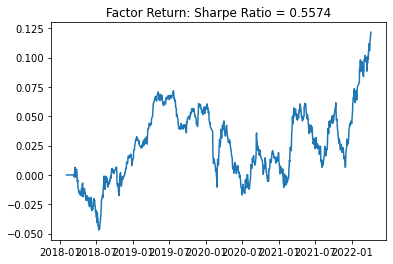

In [3]:
from factor_filter.factor_filter import PerformanceWithCost

mean_line, up_line, down_line, std = get_bollinger_band(Close)
f1 = std ** ( (up_line- Close) / std )
f2 = Close-down_line
SDate,EDate = 0,len(Close)
start = SDate
PerformanceWithCost(f1, TotalRet, 2, 0, 1, SDate, EDate)

In [18]:
# SR: 1.838 AR: 0.104 TO: 0.442
f1 =  (calculators.ts_Decay(calculators.ts_Delta(mean_line, 2), 5) * std) ** ((up_line- Close) / std )
SDate,EDate = 0,len(Close)
start = SDate
PerformanceWithCost(f1, TotalRet, 2, 0, 1, SDate, EDate)

KeyboardInterrupt: 

In [ ]:
#SR: 1.863 AR: 0.107 TO: 0.458
f1 =  (calculators.ts_Decay(calculators.ts_Delta(mean_line, 2), 3) * std) ** ((up_line- Close) / std )
SDate,EDate = 0,len(Close)
start = SDate
PerformanceWithCost(f1, TotalRet, 2, 0, 1, SDate, EDate)

SR: 1.92 AR: 0.108 TO: 0.492


(1.92,
 0.108,
 2018-02-01    0.000000
 2018-02-02    0.000000
 2018-02-05    0.000000
 2018-02-06    0.000000
 2018-02-07    0.000000
                 ...   
 2022-03-29   -0.002314
 2022-03-30   -0.003649
 2022-03-31    0.004727
 2022-04-01   -0.003026
 2022-04-06    0.005916
 Length: 1011, dtype: float64)

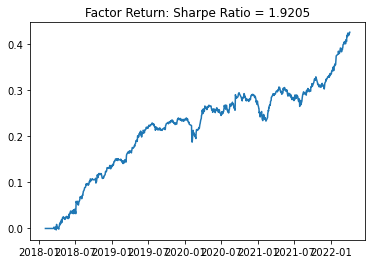

In [4]:
#SR: 1.92 AR: 0.108 TO: 0.492
f1 =  (calculators.ts_Decay(calculators.ts_Delta(mean_line, 1), 3) * std) ** ((up_line- Close) / std )
#f1[f1 < 0] = 0
SDate,EDate = 0,len(Close)
start = SDate
PerformanceWithCost(f1, TotalRet, 2, 0, 1, SDate, EDate)

In [7]:
f1.mean()

000001       1.818610
000002       3.425822
000004       4.774405
000005    1573.121448
000006      47.279634
             ...     
688331            NaN
688048            NaN
688295            NaN
301097            NaN
301268            NaN
Length: 4834, dtype: float64

In [7]:
f1 =  (calculators.ts_Decay(calculators.ts_Delta(mean_line, 1), 3) * std) ** ((up_line- Close) / (std + 0.0001) )
f1

,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,...,301102,301263,301258,301216,688193,688331,688048,688295,301097,301268
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-29,NaN,NaN,NaN,NaN,0.066939,NaN,NaN,NaN,NaN,0.069165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-30,NaN,NaN,NaN,NaN,31.610197,NaN,NaN,NaN,NaN,2.170192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-31,NaN,NaN,NaN,NaN,2.391379,NaN,NaN,NaN,NaN,3.975975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-01,1.217747,4.319018,NaN,NaN,4.641826,NaN,NaN,NaN,NaN,5.390682,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
test = calculators.ts_Decay(calculators.ts_Delta(mean_line, 1), 3)
test

,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,...,301102,301263,301258,301216,688193,688331,688048,688295,301097,301268
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-29,-0.053667,-0.089000,-0.066917,-2.500000e-04,0.016833,-0.009417,-0.010417,-0.120750,-0.015667,0.034833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-30,-0.039917,-0.052083,-0.058833,-1.416667e-03,0.027417,-0.012917,-0.009583,-0.114333,-0.015667,0.052000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-31,-0.026417,-0.030000,-0.059917,-1.416667e-03,0.032083,-0.014167,-0.010417,-0.115333,-0.014500,0.071417,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-01,0.001083,0.040250,-0.077833,-7.500000e-04,0.042333,-0.007250,-0.009083,-0.102250,-0.010667,0.122750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
test = calculators.ts_Decay(calculators.ts_Delta(mean_line, 1), 3) * std
test

,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,...,301102,301263,301258,301216,688193,688331,688048,688295,301097,301268
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-29,-0.028186,-0.103326,-0.063802,-1.623430e-05,0.003648,-0.001863,-0.001194,-0.087092,-0.001779,0.020391,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-30,-0.019608,-0.059001,-0.051989,-8.829153e-05,0.007704,-0.002318,-0.001029,-0.066605,-0.001507,0.035639,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-31,-0.012188,-0.033027,-0.050099,-8.726567e-05,0.010504,-0.002271,-0.001043,-0.055366,-0.001091,0.059745,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-01,0.000540,0.052284,-0.059115,-4.571148e-05,0.016717,-0.001162,-0.000867,-0.038237,-0.000673,0.138510,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
test = ((up_line- Close) / (std + 0.0001) )
test

,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,...,301102,301263,301258,301216,688193,688331,688048,688295,301097,301268
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-29,2.149058,1.891737,1.675214,1.258886,0.481687,2.585180,2.686666,3.047744,2.798942,0.686232,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-30,1.032794,0.550025,1.371210,1.035619,-0.709715,1.879143,1.909754,2.277697,2.366708,-0.232376,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-31,0.566117,0.338171,1.943557,0.692043,-0.191369,1.284817,2.392097,3.365828,1.897804,-0.489863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-01,-0.026185,-0.495763,2.403892,0.833717,-0.375212,-0.149290,2.222951,3.104907,1.443219,-0.852216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


SR: 0.351 AR: 0.001 TO: 0.363
SR: 1.522 AR: 0.002 TO: 1.404


(1.522,
 0.002,
 2018-02-01    0.000000
 2018-02-02    0.000000
 2018-02-05    0.000000
 2018-02-06    0.000000
 2018-02-07    0.000000
                 ...   
 2022-03-29    0.000027
 2022-03-30    0.000109
 2022-03-31    0.000015
 2022-04-01   -0.000068
 2022-04-06    0.000062
 Length: 1011, dtype: float64)

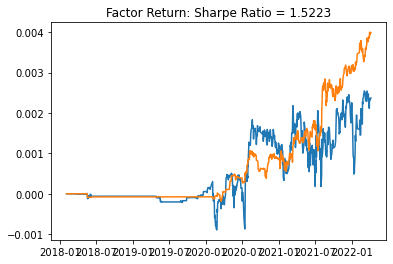

In [9]:
f4, f6 = get_EMV(Volume, High, Low)
f5 = calculators.ts_Delta(f4, 1)
SDate,EDate = 0,len(Close)
start = SDate
PerformanceWithCost(f4, TotalRet, 2, 0, 1, SDate, EDate)
#SR: 1.522 AR: 0.002 TO: 1.404
PerformanceWithCost(f5, TotalRet, 2, 0, 1, SDate, EDate)

SR: 0.918 AR: 0.003 TO: 0.437
SR: 0.517 AR: 0.001 TO: 0.667


(0.517,
 0.001,
 2018-02-01    0.000000
 2018-02-02    0.000000
 2018-02-05    0.000000
 2018-02-06    0.000000
 2018-02-07    0.000000
                 ...   
 2022-03-29    0.000056
 2022-03-30   -0.000031
 2022-03-31   -0.000086
 2022-04-01   -0.000088
 2022-04-06   -0.000066
 Length: 1011, dtype: float64)

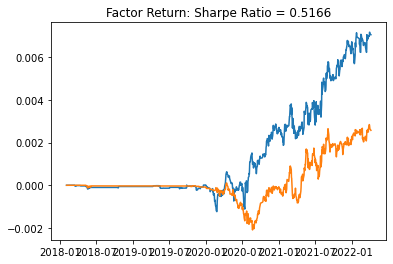

In [10]:
f7 = (f4 - f6)
# SR: 0.918 AR: 0.003 TO: 0.437
PerformanceWithCost(f6, TotalRet, 2, 0, 1, SDate, EDate)
PerformanceWithCost(f7, TotalRet, 2, 0, 1, SDate, EDate)

SR: 0.645 AR: 0.027 TO: 0.49


(0.645,
 0.027,
 2018-02-01    0.000000
 2018-02-02    0.000000
 2018-02-05    0.000000
 2018-02-06    0.000000
 2018-02-07    0.000000
                 ...   
 2022-03-29   -0.001484
 2022-03-30    0.000034
 2022-03-31   -0.004297
 2022-04-01   -0.002787
 2022-04-06   -0.004971
 Length: 1011, dtype: float64)

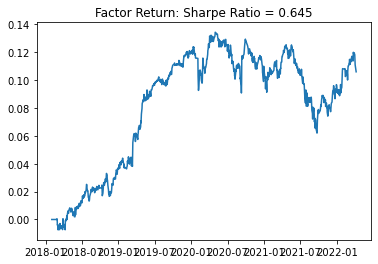

In [4]:
CMO = get_CMO(Close, 10)
CMO[CMO < 0] = 0
SDate,EDate = 0,len(Close)
start = SDate
PerformanceWithCost(CMO, TotalRet, 2, 0, 1, SDate, EDate)

SR: 0.123 AR: 0.001 TO: 1.882


(0.123,
 0.001,
 2018-02-01    0.000000
 2018-02-02    0.000000
 2018-02-05    0.000000
 2018-02-06    0.000000
 2018-02-07    0.000000
                 ...   
 2022-03-29    0.000155
 2022-03-30   -0.000552
 2022-03-31    0.000194
 2022-04-01    0.000294
 2022-04-06   -0.000051
 Length: 1011, dtype: float64)

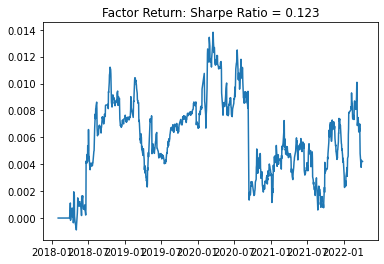

In [11]:
volume, DIF, DIF_EMA9 = get_MACD(Close)

DIF_DIF = DIF - DIF_EMA9
C_DIF_DIF = DIF_DIF * calculators.ts_Delay(DIF_DIF, 1)
C_DIF_DIF[C_DIF_DIF > 0] = 0
f9 = -1 * C_DIF_DIF * calculators.ts_Delta(DIF, 1)

PerformanceWithCost(f9, TotalRet, 2, 0, 1, SDate, EDate)

SR: 0.938 AR: 0.036 TO: 0.573


(0.938,
 0.036,
 2018-02-01    0.000000
 2018-02-02    0.000000
 2018-02-05    0.000000
 2018-02-06    0.000000
 2018-02-07    0.000000
                 ...   
 2022-03-29    0.000829
 2022-03-30   -0.002213
 2022-03-31    0.002259
 2022-04-01    0.000875
 2022-04-06    0.006101
 Length: 1011, dtype: float64)

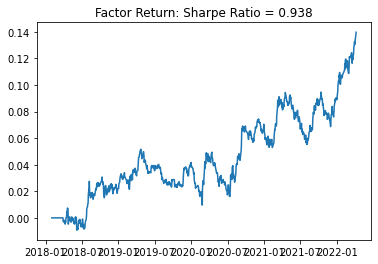

In [14]:
#SR: 0.938 AR: 0.036 TO: 0.573
PerformanceWithCost(DIF_DIF *  calculators.ts_Delta(DIF, 1), TotalRet, 2, 0, 1, SDate, EDate)

In [ ]:
PerformanceWithCost(C_DIF_DIF, TotalRet, 2, 0, 1, SDate, EDate)

In [17]:
file = os.path.join('../', 'raw_data', 'Px_new.mat')
data1 = mat73.loadmat(file)
data1 = data1['Px']

col = data1['LocalID']
ind = tools.ConTimeDay(data1)
ind = tools.Str2times(ind)

Volume = data1['Volume']  # 日交易量
Volume = pd.DataFrame(Volume)
Volume.columns = col
Volume.index = ind
Volume = Volume.iloc[Volume.index >= '2018-01-01']



Amount = data1['Value']
Amount = pd.DataFrame(Amount)
Amount.columns = col
Amount.index = ind
Amount = Amount.iloc[Amount.index >= '2018-01-01']


listed = Volume.copy()
listed[listed.isna()] = 0
listed = listed.cumsum()  # get the cumsum values
listed = listed.shift(30)
listed[listed.isna()] = 0

Amount[listed == 0] = np.nan


TradeDay = Amount.sum(1)
TradeDay[TradeDay > 0] = 1
del Amount

Close = data1['AdjClose']
Close = pd.DataFrame(Close)
Close.columns = col
Close.index = ind
Close2 = Close[Close.index >= '2018-01-01']
Close2 = Close2[TradeDay == 1]

Rate = Close2 / Close2.shift(1) - 1  # 收盘价/昨日收盘价-1
Rate = Rate[Rate.index >= '2018-01-01']
